<a href="https://colab.research.google.com/github/Cryptonex7/covid19-analysis/blob/collab-files/TestingCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

# Supress Warnings
import warnings
warnings.simplefilter('ignore')

In [0]:
# Function for fetching url
import requests

def get(url):
  try:
    response = requests.get(url)
    print(f"Request returned {response.status_code} : '{response.reason}'")
    return response.json()
  except requests.HTTPError:
    print(response.status_code, response.reason)
    raise

## Fetching Data

In [0]:
# Fetching and Parsing the data
raw_data = get('https://api.covid19india.org/raw_data.json')
raw_data = raw_data['raw_data']

Request returned 200 : 'OK'


### Web Scraping

In [0]:
# Function for fetching url
import requests

def get(url):
  try:
    response = requests.get(url)
    print(f"Request returned {response.status_code} : '{response.reason}'")
    return response.json()
  except requests.HTTPError:
    print(response.status_code, response.reason)
    raise

In [0]:
# Fetching data from 2nd source
from datetime import datetime
import requests
import os
import glob
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [0]:
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSc_2y5N0I67wDU38DjDh35IZSIS30rQf7_NYZhtYYGU1jJYT6_kDx4YpF-qw0LSlGsBYP8pqM_a1Pd/pubhtml#'
req = requests.get(link)
soup = BeautifulSoup(req.content, "html.parser")

In [0]:
def getDataFromSheet(id, index):
  table = soup.find(id=id).div.table
  tbody = table.tbody
  body = tbody.find_all('tr')

  body_rows = []
    
  for tr in body:
      td = tr.find_all(['th', 'td'])
      row = [i.text for i in td]
      body_rows.append(row)
    
  data = pd.DataFrame(body_rows[index:len(body_rows)], columns=body_rows[0])

  data.drop(data.columns[0], axis='columns', inplace=True)
  return data

In [0]:
# And there we have it! the data, the Statewise data

statewise_data = getDataFromSheet(id='1896310216', index=1)
statewise_data.drop(statewise_data.index[1], axis='index', inplace=True)

In [0]:
# Import gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
statewise_data.columns

Index(['State', '', 'Confirmed', 'Recovered', 'Deaths', 'Active',
       'Last_Updated_Time', 'State_code', 'Delta_Confirmed', 'Delta_Recovered',
       'Delta_Deaths'],
      dtype='object')

# Date Wrangling

In [0]:
# JSON to dataframe
from pandas.io.json import json_normalize
data = json_normalize(raw_data)

In [0]:
statewise_data.drop('',axis=1,inplace=True)

KeyError: ignored

In [0]:
data = data.rename(columns={"patientnumber": "ID",
                     "statepatientnumber": "Government id",
                     "dateannounced": "Diagnosed date",
                     "agebracket": "Age",
                     "gender": "Gender",
                     "detectedcity": "Detected city",
                     "detecteddistrict": "Detected district",
                     "detectedstate": "Detected state",
                     "nationality": "Nationality",
                     "currentstatus": "Current status",
                     "statuschangedate": "Status change date",
                     "_d180g": "Notes",
                     "backupnotes": "Backup notes",
                     "contractedfromwhichpatientsuspected": "Contracted from which Patient (Suspected)",
                     "estimatedonsetdate": "Estimated on set date",
                     "source1": "Source 1",
                     "source2": "Source 2",
                     "source3": "Source 3"}
                   )

In [0]:
# changing nationality Indian to India
for ind in data.index:
  if(data['Nationality'][ind] == "Indian"):
    data['Nationality'][ind] = "India"

In [0]:
#converting the string values to datetime object
data['Diagnosed date'] = pd.to_datetime(data['Diagnosed date'],dayfirst=True)
data['Status change date'] = pd.to_datetime(data['Status change date'],dayfirst=True)

In [0]:
#replacing all the missing values with unknown
data.replace(to_replace ="", 
                 value ="unknown", inplace=True)
#creating new columns depicting the current status of patient
data['recovered'] = 0
data['active'] = 0
data['death'] = 0
data['unknown'] = 0
data['confirmed'] = 1

In [0]:
for status in data.index:  
  if(data['Current status'][status] == "Hospitalized"):
    data['active'][status] = 1
  elif(data['Current status'][status] == "Recovered"):
    data['recovered'][status] = 1
  elif(data['Current status'][status] == "Deceased"):
    data['death'][status] = 1
  else:
    data['unknown'][status] = 1   

data[['Current status','recovered','active','death','unknown']].sample(5)

,Current status,recovered,active,death,unknown
5164,Hospitalized,0,1,0,0
5650,Hospitalized,0,1,0,0
7193,Hospitalized,0,1,0,0
4411,Hospitalized,0,1,0,0
3636,Hospitalized,0,1,0,0


In [0]:
statewise_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 38
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              38 non-null     object 
 1   Confirmed          38 non-null     float64
 2   Recovered          38 non-null     object 
 3   Deaths             38 non-null     object 
 4   Active             38 non-null     object 
 5   Last_Updated_Time  38 non-null     object 
 6   State_code         38 non-null     object 
 7   Delta_Confirmed    38 non-null     object 
 8   Delta_Recovered    38 non-null     object 
 9   Delta_Deaths       38 non-null     object 
dtypes: float64(1), object(9)
memory usage: 4.5+ KB


In [0]:
statewise_data['Confirmed'] = statewise_data['Confirmed'].astype(float)
statewise_data['Recovered'] = statewise_data['Recovered'].astype(float)
statewise_data['Deaths'] = statewise_data['Deaths'].astype(float)
statewise_data['Active'] = statewise_data['Active'].astype(float)
statewise_data['Delta_Recovered'] = statewise_data['Delta_Confirmed'].astype(float)
statewise_data['Delta_Deaths'] = statewise_data['Delta_Deaths'].astype(float)

# Understanding the Data

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9278 entries, 0 to 9277
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Age                                        9278 non-null   object        
 1   Backup notes                               9278 non-null   object        
 2   Contracted from which Patient (Suspected)  9278 non-null   object        
 3   Current status                             9278 non-null   object        
 4   Diagnosed date                             9206 non-null   datetime64[ns]
 5   Detected city                              9278 non-null   object        
 6   Detected district                          9278 non-null   object        
 7   Detected state                             9278 non-null   object        
 8   Estimated on set date                      9278 non-null   object        
 9   Gender             

In [0]:
data.sample(5)

,Age,Backup notes,Contracted from which Patient (Suspected),Current status,Diagnosed date,Detected city,Detected district,Detected state,Estimated on set date,Gender,Nationality,notes,ID,Source 1,Source 2,Source 3,statecode,Government id,Status change date,typeoftransmission,recovered,active,death,unknown,confirmed
2034,unknown,unknown,unknown,Hospitalized,2020-04-01,unknown,Hyderabad,Telangana,unknown,unknown,unknown,Details awaited,2035,https://twitter.com/Eatala_Rajender/status/124...,unknown,unknown,TG,unknown,2020-04-01,unknown,0,1,0,0,1
7351,unknown,unknown,unknown,Hospitalized,2020-04-10,unknown,Mumbai,Maharashtra,unknown,unknown,unknown,Details awaited,7353,https://twitter.com/rajeshtope11/status/124864...,unknown,unknown,MH,unknown,2020-04-10,unknown,0,1,0,0,1
54,unknown,Mother of P43,P43,Recovered,2020-03-10,Kochi,Ernakulam,Kerala,unknown,F,India,Mother of P43,55,https://www.livemint.com/news/india/coronaviru...,https://english.manoramaonline.com/news/kerala...,https://www.facebook.com/kkshailaja/posts/2892...,KL,KL-EL-P2,2020-03-26,Local,1,0,0,0,1
7429,unknown,unknown,unknown,Hospitalized,2020-04-10,unknown,Mumbai,Maharashtra,unknown,unknown,unknown,Details awaited,7431,https://twitter.com/rajeshtope11/status/124864...,unknown,unknown,MH,unknown,2020-04-10,unknown,0,1,0,0,1
8031,unknown,unknown,unknown,Hospitalized,2020-04-11,unknown,Ahmadabad,Gujarat,unknown,M,unknown,Details awaited,8033,https://twitter.com/PIBAhmedabad/status/124898...,unknown,unknown,GJ,unknown,2020-04-11,unknown,0,1,0,0,1


In [0]:
print("External Data")
print(f"First recorded Case: {data['Diagnosed date'].min()}")
print(f"Last recorded Case: {data['Diagnosed date'].max()}")
print(f"Total Days recorded: {data['Diagnosed date'].max() - data['Diagnosed date'].min()}")

External Data
First recorded Case: 2020-01-30 00:00:00
Last recorded Case: 2020-04-12 00:00:00
Total Days recorded: 73 days 00:00:00


# Country Analysis

## 1. Confirmed Cases Over Time


### 1.1 Confirmed Cases ( Cumulative )

In [0]:
grouped = data.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()
s=0
grouped['tot_confirmed'] = grouped['confirmed']
for row in grouped.index:
  grouped['tot_confirmed'][row] += s
  s = grouped['tot_confirmed'][row]  

In [0]:
fig = px.line(grouped, x="Diagnosed date", y="tot_confirmed", title="Day Wise Overall Confirmed Cases in India", width=900, height=650)

fig.show()

print("\n")

fig = px.line(grouped, x="Diagnosed date", y="tot_confirmed", title="Day Wise Confirmed Cases in India(Logarithmic Scale)", log_y=True, width=900, height=650)

fig.show()

### 1.2 Confirmed Cases ( Day Wise )

In [0]:
fig = px.line(grouped, x="Diagnosed date", y="confirmed", title="Day Wise Encountered Cases in India", width=900, height=650)

fig.show()

print("\n")

fig = px.line(grouped, x="Diagnosed date", y="confirmed", title="Day Wise Encountred Cases in India(Logarithmic Scale)", log_y=True, width=900, height=650)

fig.show()

## Observation from the above graph:

## 2. Total Confirmed Cases in Various States till Date

In [0]:
statewise_data.columns

Index(['State', 'Confirmed', 'Recovered', 'Deaths', 'Active',
       'Last_Updated_Time', 'State_code', 'Delta_Confirmed', 'Delta_Recovered',
       'Delta_Deaths'],
      dtype='object')

In [0]:
statewise_data['Confirmed'] = statewise_data['Confirmed'].astype(float)
#cases state wise
state_grouped = statewise_data.groupby(['State'])['Confirmed'].sum().reset_index()

fig = px.bar(state_grouped[state_grouped['State']!='Total'].sort_values('Confirmed', ascending=False)[:40][::-1], 
             x='Confirmed', y='State',
             title='Confirmed Cases in Various States in India', text='Confirmed', height=800,width = 1400, orientation='h')
fig.show()

In [0]:
# # All these will be shifted to new notebook
# grouped_Kerala = data[data['Detected state'] == "Kerala"].reset_index()
# grouped_Kerala_date = grouped_Kerala.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()

# # grouped_Maharashtra = data[data['Detected state'] == "Maharashtra"].reset_index()
# grouped_Maharashtra_date = grouped_Maharashtra.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()

# grouped_Karnataka = data[data['Detected state'] == "Karnataka"].reset_index()
# grouped_Karnataka_date = grouped_Karnataka.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()

# grouped_rest = data[~data['Detected state'].isin(['Maharashtra', 'Kerala', 'Karnataka'])].reset_index()
# grouped_rest_date = grouped_rest.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()

In [0]:
# plot_titles = ['Maharashtra', 'Kerala', 'Karnataka', 'Rest of the India']

# fig = px.line(grouped_Maharashtra_date, x="Diagnosed date", y="confirmed", 
#               title=f"Confirmed Cases in {plot_titles[0].upper()} Day-Wise", 
#               color_discrete_sequence=['#F61067'],
#               height=500
#              )
# fig.show()


# fig = px.line(grouped_Kerala_date, x="Diagnosed date", y="confirmed", 
#               title=f"Confirmed Cases in {plot_titles[1].upper()} Day-Wise", 
#               color_discrete_sequence=['#91C4F2'],
#               height=500
#              )
# fig.show()

# fig = px.line(grouped_Karnataka_date, x="Diagnosed date", y="confirmed", 
#               title=f"Confirmed Cases in {plot_titles[2].upper()} Day-Wise", 
#               color_discrete_sequence=['#6F2DBD'],
#               height=500
#              )
# fig.show()

# fig = px.line(grouped_rest_date, x="Diagnosed date", y="confirmed", 
#               title=f"Confirmed Cases in {plot_titles[3].upper()} Day-Wise", 
#               color_discrete_sequence=['#FFDF64'],
#               height=500
#              )
# fig.show()

In [0]:
# # Plotting the same for observing trend in Rajasthan
# grouped_Rajasthan = data[data['Detected state'] == "Rajasthan"].reset_index()
# grouped_Rajasthan_date = grouped_Rajasthan.groupby('Diagnosed date')['Diagnosed date', 'confirmed'].sum().reset_index()

# fig = px.line(grouped_Rajasthan_date, x="Diagnosed date", y="confirmed", 
#               title=f"Confirmed Cases in Rajasthan Day-Wise", 
#               color_discrete_sequence=['#6F2DBD'],
#               height=500
#              )
# fig.show()

In [0]:
latest_grouped = data.groupby('Nationality')['confirmed'].sum().reset_index()
latest_grouped

,Nationality,confirmed
0,Canada,1
1,India,1171
2,Indonesia,15
3,Italy,18
4,Malaysia,1
5,Myanmar,1
6,Phillipines,2
7,Thailand,2
8,Tibet,1
9,United Kingdom,7


In [0]:
fig = px.choropleth(latest_grouped, locations="Nationality", 
                    locationmode='country names', color="confirmed", 
                    hover_name="Nationality", range_color=[1,1500], 
                    color_continuous_scale="peach", scope='world',
                    title='Countries with Confirmed Cases')
#fig.update(layout_coloraxis_showscale=False)
fig.show()

In [0]:
# Remove all the unknown Genders
df_gender_cleaned = data[data['Gender']!="unknown"]
print('Percentage of gender unknown = ',(data['Gender'].value_counts()[0]) / (data['Gender'].value_counts().sum())*100)

# Pie Chart
fig = px.pie(df_gender_cleaned,values='confirmed', names='Gender')
fig.show()

Percentage of gender unknown =  78.13106272903643


In [0]:
# Observation
ratio = df_gender_cleaned['Gender'].value_counts()[0] / df_gender_cleaned['Gender'].value_counts()[1]
print("\nAlthough more than 50% of the genders of people affected with covid19 is unknown but from the ones that are known we can see that almost\n{} times the number of Males are getting affected by COVID-19 in India. ".format(0.5*round(ratio/0.5)))


Although more than 50% of the genders of people affected with covid19 is unknown but from the ones that are known we can see that almost
2.5 times the number of Males are getting affected by COVID-19 in India. 


 - This may be indicative of a greater number of males, highlighting the already present gender disparity in India, but at the same time may be attributed to smoking, drinking, general poor health practiced by a greater number of men in the Indian subcontinent as compared to women .

- Since coronavirus spreads from person to person, it is quite obvious that chances of a person getting in contact with coronavirus increases when he/she is at workplace or at some crowded place.
 - According to a website catalyst(https://www.catalyst.org/research/women-in-the-workforce-india/) the male workforce is 78.6% compared to 23.6% of female workforce in India. This can be another reason of more males getting affected with the virus.






## **DISTRICT WISE ANALYSIS**

In [0]:
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Mumbai', case=False), 'Detected city'] = "Mumbai"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Noida', case=False), 'Detected city'] = "Noida"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Delhi', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Bengaluru', case=False), 'Detected city'] = "Bengaluru"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Janakpuri', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Uttam Nagar', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Tri Nagar', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Chuchot', case=False), 'Detected city'] = "Leh"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Nedumangad', case=False), 'Detected city'] = "Thiruvananthapuram"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Kalanadu', case=False), 'Detected city'] = "Kasaragod"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Saket', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Khanyar', case=False), 'Detected city'] = "Srinagar"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Dilshad Garden', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Rana Pratap Bagh', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Ashok Vihar', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Gautam Puri', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Beleghata', case=False), 'Detected city'] = "Kolkata"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Chusot', case=False), 'Detected city'] = "Leh"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Jahangirpuri', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Sankoo Valley', case=False), 'Detected city'] = "Kargil"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Dum Dum', case=False), 'Detected city'] = "Kolkata"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Lakhapt', case=False), 'Detected city'] = "Lakhpat"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Shashtri Nagar', case=False), 'Detected city'] = "Delhi"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Balkampet', case=False), 'Detected city'] = "Hyderabad"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Saidabad', case=False), 'Detected city'] = "Hyderabad"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Somajiguda', case=False), 'Detected city'] = "Hyderabad"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Purasaivakkam', case=False), 'Detected city'] = "Chennai"
# df_city_cleaned.loc[df_city_cleaned['Detected city'].str.contains('Keelkattalai', case=False), 'Detected city'] = "Kancheepuram"

# df_city_cleaned['Detected city'].unique()


In [0]:
df_district_cleaned = data[data['Detected district']!="unknown"]

latest_grouped = df_district_cleaned.groupby('Detected district')['confirmed'].sum().reset_index()

fig = px.bar(latest_grouped.sort_values('confirmed', ascending=False)[:20][::-1], 
             x='confirmed', y='Detected district',
             title='20 most affected Districts in India', text='confirmed', height=850, orientation='h')
fig.show()

Maharashtra is heavily affected
> Mumbai being the hub for tourist arrivals and international flights, as well as the most populous city in india and 5th most populous city worldwide has been the most affected city thus far.

>Pune being close to Mumbai (~150 Km) is also affected heavily thanks to inter city travel between the major neighbouring cities.





Here we form a hypothesis that there seems to be a correlation between the cities the virus is spreading in a greater number & said cities being costal areas.

With this hypothesis, let us explore this idea and see if we can reach any conclusions-

In [0]:
data['Detected district'].unique()

array(['Thrissur', 'Alappuzha', 'Kasaragod', 'East Delhi', 'Hyderabad',
       'Italians*', 'Agra', 'South West Delhi', 'Ghaziabad', 'West Delhi',
       'Leh', 'Kancheepuram', 'Pathanamthitta', 'North Delhi', 'Jammu',
       'Bengaluru', 'Kannur', 'Pune', 'Amritsar', 'Ernakulam', 'Kottayam',
       'Jaipur', 'Mumbai', 'S.P.S. Nellore', 'Kalaburagi', 'Nagpur',
       'Lucknow', 'New Delhi', 'Thiruvananthapuram', 'Ahmadnagar',
       'Thane', 'Raigarh', 'Yavatmal', 'Idukki', 'Aurangabad', 'Dehradun',
       'Malappuram', 'Khordha', 'South Delhi', 'Gurugram', 'Kargil',
       'Mahe', 'Gautam Buddha Nagar', 'Kolkata', 'Chennai', 'Ratnagiri',
       'Srinagar', 'Jhunjhunu', 'North East Delhi', 'Chandigarh',
       'Kodagu', 'Prakasam', 'Raipur', 'Kheri',
       'Shahid Bhagat Singh Nagar', 'Rajkot', 'Surat', 'Visakhapatnam',
       'North West Delhi', 'S.A.S. Nagar', 'Ahmadabad', 'Vadodara',
       'Bhilwara', 'Faridabad', 'Panipat', 'Kangra', 'Jabalpur',
       'Karimnagar', 'unknown', 'N

In [0]:
# Finding number of patients in districts with humid climate
most_affected_districts = df_district_cleaned

close_to_water = most_affected_districts[most_affected_districts["Detected district"].isin(["Mumbai", "Kasaragod", "Pune", "Kochi", "Sangli",'Chennai'])] #Ahemdabad is ~326km from the sea, vadodra ~263, "Sangli city is situated on the bank of Krishna river", 

#Segregate the remaining cities
far_from_water = most_affected_districts[~(most_affected_districts["Detected district"].isin(["Mumbai", "Kasaragod", "Pune", "Kochi", "Sangli"]))]

#Calculate the total number of confirmed cases in the two cases
x = close_to_water['confirmed'].sum()
y = far_from_water['confirmed'].sum()

#Lists used to feed the pie chart
labels = ['Close to water','Far from water']
values = [x,y]

# plotting a Pie chart to see the distribution of confirmed cases in the two cases
fig = go.Figure(data=[go.Pie(labels=labels, values = values,pull=0.05)])
fig.show()

From the above data we can say that at this time no such conclusion can be derived, as most of the cases seem to come from inland cities as far as th

# Recovered Cases




In [0]:
# district Wise Recovery
latest_grouped = data.groupby('Detected district')['recovered'].sum().reset_index()

fig = px.bar(latest_grouped.sort_values('recovered', ascending=False)[:7][::-1], 
             x='recovered', y='Detected district',
             title='Recovered cases district-wise in India: ', text='recovered', height=400, orientation='h')
fig.show()

mostRecovered = latest_grouped.loc[latest_grouped['recovered'] == latest_grouped['recovered'].max(), 'Detected district'].item()

print("\n{} seems to be the best place to get a treatment for the vaishvik mahamaari right now\n".format(mostRecovered))

# State Wise Recovery
fig = px.bar(statewise_data[statewise_data['State']!='Total'].sort_values('Recovered', ascending=False)[:7][::-1], 
             x='Recovered', y='State',
             title='Recovered cases state-wise in India: ', text='Recovered', height=400, orientation='h')
fig.show()


Bengaluru seems to be the best place to get a treatment for the vaishvik mahamaari right now



In [0]:
# temp = data.groupby('Diagnosed date')['confirmed'].sum().reset_index()
# temp = temp.melt(id_vars="Diagnosed date", value_vars='confirmed',
#                   var_name='Current status', value_name='freq')

# fig = px.line(temp, x="Diagnosed date", y="freq", color='Current status',
#               title='Cases over time: Line Plot', color_discrete_sequence = ['cyan', 'red', 'orange'])
# fig.show()

# Confirmed Deaths 

In [0]:
data['Current status'].unique()

array(['Recovered', 'Hospitalized', 'Deceased', 'Migrated', 'unknown'],
      dtype=object)

In [0]:
death_daywise = data.groupby('Diagnosed date')['death'].sum().reset_index()

In [0]:
fig = px.line(death_daywise, x="Diagnosed date", y="death", title="Deaths Day Wise in India",
             color_discrete_sequence=['#F42272'])
fig.show()

In [0]:
#deaths state wise
death_grouped = data.groupby(['Detected state'])['death'].sum().reset_index()

fig = px.bar(death_grouped.sort_values('death', ascending=False)[:9][::-1], 
             x='death', y='Detected state',
             title='Deaths in Various States in India', text='death', height=400,width = 1000, orientation='h')
fig.show()

#deaths district wise
death_grouped = df_district_cleaned.groupby(['Detected district'])['death'].sum().reset_index()

fig = px.bar(death_grouped.sort_values('death', ascending=False)[:9][::-1], 
             x='death', y='Detected district',
             title='Deaths in Various Cities in India', text='death', height=400, width = 1000, orientation='h')
fig.show()

## Observations based on Above Graphs

# Comparisons

*** This needs to be resolved ***

In [0]:
'''updated_data = pd.read_excel('Latest_data.xlsx',parse_dates=['Last_Updated_Time'])
updated_data.head()'''

"updated_data = pd.read_excel('Latest_data.xlsx',parse_dates=['Last_Updated_Time'])\nupdated_data.head()"

In [0]:
'''import datetime as dt

#function to change the time 
def change_time(date):
  newdate = date.replace(hour=00, minute=00, second=00)
  return newdate

updated_data['Last_Updated_Time'] = updated_data['Last_Updated_Time'].apply(change_time)
updated_data.sample(5)'''

"import datetime as dt\n\n#function to change the time \ndef change_time(date):\n  newdate = date.replace(hour=00, minute=00, second=00)\n  return newdate\n\nupdated_data['Last_Updated_Time'] = updated_data['Last_Updated_Time'].apply(change_time)\nupdated_data.sample(5)"

In [0]:
temp = data.groupby('Diagnosed date')['recovered', 'death', 'active'].sum().reset_index()
temp = temp.melt(id_vars="Diagnosed date", value_vars=['recovered', 'death', 'active'],
                 var_name='case', value_name='count')

print(temp.head())
fig = px.line(temp, x="Diagnosed date", y="count", color='case',
             title='Cases over time: Line Plot', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.show()


fig = px.area(temp, x="Diagnosed date", y="count", color='case',
             title='Cases over time: Area Plot', color_discrete_sequence = ['cyan', 'red', 'orange'])
fig.show()

  Diagnosed date       case  count
0     2020-01-30  recovered      1
1     2020-02-02  recovered      1
2     2020-02-03  recovered      1
3     2020-03-02  recovered      2
4     2020-03-03  recovered      1


## Observations based on above graph:

# Mortality Rate

In [0]:
flg = data.groupby('Detected state')['confirmed', 'death', 'recovered', 'active'].sum().reset_index()

flg['mortalityRate'] = round((flg['death']/flg['confirmed'])*100, 2)

temp = flg[flg['confirmed']>10]
temp = temp.sort_values('mortalityRate', ascending=False)

# print(flg)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:8][::-1],
             x = 'mortalityRate', y = 'Detected state', 
             title='Deaths per 10 Confirmed Cases', text='mortalityRate', height=500, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

## Observations based on above gragh

# Recovery Rate

In [0]:
flg['recoveryRate'] = round((flg['recovered']/flg['confirmed'])*100, 2)
#print(flg[['Detected state','recovered']])
temp = flg[flg['confirmed']>10]
temp = temp.sort_values('recoveryRate', ascending=False)

# print(flg)

fig = px.bar(temp.sort_values(by="recoveryRate", ascending=False)[:8][::-1],
             x = 'recoveryRate', y = 'Detected state', 
             title='Recovery per 10 Confirmed Cases', text='recoveryRate', height=500, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

## Observation based on above graph

In [0]:
#Failed attempt
'''formated_gdf = data.groupby(['Diagnosed date', 'Detected state'])['active', 'death'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['Diagnosed date'] = pd.to_datetime(formated_gdf['Diagnosed date'])
formated_gdf['Diagnosed date'] = formated_gdf['Diagnosed date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['active'].pow(0.3)

fig = px.scatter_geo(formated_gdf, locations="Detected state", locationmode='country names', 
                     color="active", size='size', hover_name="Detected state", 
                     range_color= [0, 150], 
                     projection="natural earth", animation_frame="Diagnosed date", 
                     title='COVID-19: Spread Over Time', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()'''

'formated_gdf = data.groupby([\'Diagnosed date\', \'Detected state\'])[\'active\', \'death\'].max()\nformated_gdf = formated_gdf.reset_index()\nformated_gdf[\'Diagnosed date\'] = pd.to_datetime(formated_gdf[\'Diagnosed date\'])\nformated_gdf[\'Diagnosed date\'] = formated_gdf[\'Diagnosed date\'].dt.strftime(\'%m/%d/%Y\')\nformated_gdf[\'size\'] = formated_gdf[\'active\'].pow(0.3)\n\nfig = px.scatter_geo(formated_gdf, locations="Detected state", locationmode=\'country names\', \n                     color="active", size=\'size\', hover_name="Detected state", \n                     range_color= [0, 150], \n                     projection="natural earth", animation_frame="Diagnosed date", \n                     title=\'COVID-19: Spread Over Time\', color_continuous_scale="portland")\n# fig.update(layout_coloraxis_showscale=False)\nfig.show()'

In [0]:
data[data['Detected state']=='Haryana']

,Age,Backup notes,Contracted from which Patient (Suspected),Current status,Diagnosed date,Detected city,Detected district,Detected state,Estimated on set date,Gender,Nationality,notes,ID,Source 1,Source 2,Source 3,statecode,Government id,Status change date,typeoftransmission,recovered,active,death,unknown,confirmed
6,55,Italian tourist,P6,Recovered,2020-03-04,Gurugram,Italians*,Haryana,unknown,unknown,Italy,Travelled from Italy,7,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,unknown,HR,unknown,2020-03-29,Imported,1,0,0,0,1
7,55,Italian tourist,P6,Recovered,2020-03-04,Gurugram,Italians*,Haryana,unknown,unknown,Italy,Travelled from Italy,8,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,unknown,HR,unknown,2020-03-29,Imported,1,0,0,0,1
8,55,Italian tourist,P6,Recovered,2020-03-04,Gurugram,Italians*,Haryana,unknown,unknown,Italy,Travelled from Italy,9,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,unknown,HR,unknown,2020-03-29,Imported,1,0,0,0,1
9,55,Italian tourist,P6,Recovered,2020-03-04,Gurugram,Italians*,Haryana,unknown,unknown,Italy,Travelled from Italy,10,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,unknown,HR,unknown,2020-03-29,Imported,1,0,0,0,1
10,55,Italian tourist,P6,Recovered,2020-03-04,Gurugram,Italians*,Haryana,unknown,unknown,Italy,Travelled from Italy,11,https://indianexpress.com/article/india/corona...,https://www.indiatoday.in/india/story/coronavi...,unknown,HR,unknown,2020-03-29,Imported,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6822,unknown,unknown,unknown,Hospitalized,2020-04-10,unknown,Ambala,Haryana,unknown,unknown,unknown,Details awaited,6823,http://www.nhmharyana.gov.in/WriteReadData/use...,unknown,unknown,HR,unknown,2020-04-10,unknown,0,1,0,0,1
6823,unknown,unknown,unknown,Hospitalized,2020-04-10,unknown,Panchkula,Haryana,unknown,unknown,unknown,Details awaited,6824,http://www.nhmharyana.gov.in/WriteReadData/use...,unknown,unknown,HR,unknown,2020-04-10,unknown,0,1,0,0,1
6824,unknown,unknown,unknown,Hospitalized,2020-04-10,unknown,Sonipat,Haryana,unknown,unknown,unknown,Details awaited,6825,http://www.nhmharyana.gov.in/WriteReadData/use...,unknown,unknown,HR,unknown,2020-04-10,unknown,0,1,0,0,1
6912,unknown,unknown,unknown,Hospitalized,2020-04-10,unknown,Ambala,Haryana,unknown,unknown,unknown,Details awaited,6913,http://www.nhmharyana.gov.in/WriteReadData/use...,unknown,unknown,HR,unknown,2020-04-10,unknown,0,1,0,0,1


# KEY ERROR HERE

In [0]:
# statewise_data_with_prev_wo_dup.head(1)

In [0]:
'''#Gramphs using the updated dataset
flg = statewise_data_with_prev_wo_dup.groupby('State')['Total Confirmed cases (Indian National)', 'Death', 'Cured/Discharged/Migrated'].sum().reset_index()
flg['mortalityRate'] = round((flg['Death']/flg['Total Confirmed cases (Indian National)'])*100, 2)

temp = flg[flg['Total Confirmed cases (Indian National)']>10]
temp = temp.sort_values('mortalityRate', ascending=False)
print(flg)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:8][::-1],
              x = 'mortalityRate', y = 'State', 
              title='Deaths per 10 Confirmed Cases', text='mortalityRate', height=500, orientation='h',
              color_discrete_sequence=['darkred']
             )
fig.show()'''

'#Gramphs using the updated dataset\nflg = statewise_data_with_prev_wo_dup.groupby(\'State\')[\'Total Confirmed cases (Indian National)\', \'Death\', \'Cured/Discharged/Migrated\'].sum().reset_index()\nflg[\'mortalityRate\'] = round((flg[\'Death\']/flg[\'Total Confirmed cases (Indian National)\'])*100, 2)\n\ntemp = flg[flg[\'Total Confirmed cases (Indian National)\']>10]\ntemp = temp.sort_values(\'mortalityRate\', ascending=False)\nprint(flg)\n\nfig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:8][::-1],\n              x = \'mortalityRate\', y = \'State\', \n              title=\'Deaths per 10 Confirmed Cases\', text=\'mortalityRate\', height=500, orientation=\'h\',\n              color_discrete_sequence=[\'darkred\']\n             )\nfig.show()'

In [0]:
# #recovery rate
# flg['RecoveryRate'] = round((flg['Cured/Discharged/Migrated']/flg['Total Confirmed cases (Indian National)'])*100, 2)

# temp = flg[flg['Total Confirmed cases (Indian National)']>10]
# temp = temp.sort_values('RecoveryRate', ascending=False)

# # print(flg)

# fig = px.bar(temp.sort_values(by="RecoveryRate", ascending=False)[:8][::-1],
#              x = 'RecoveryRate', y = 'State', 
#              title='Recovery per 10 Confirmed Cases', text='RecoveryRate', height=500, orientation='h',
#              color_discrete_sequence=['darkred']
#             )
# fig.show()

https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions

https://www.kaggle.com/frlemarchand/covid-19-forecasting-with-an-rnn

# Travel History Analysis

In [0]:
# Filter all the Travel data and pick all instances > 5:
notes_cleaned = data[data["notes"].str.contains("Travelled", na=False)]
v = notes_cleaned[['notes']]
notes_cleaned = notes_cleaned[v.replace(v.stack().value_counts()).gt(5).all(1)]

notes_cleaned['notes'].unique()

array(['Travelled from Italy', 'Travelled from Dubai',
       'Travelled from Middle East', 'Travelled from UK',
       'Travelled from Saudi Arabia', 'Travelled from London',
       'Travelled from Dubai, UAE', 'Travelled from Delhi',
       'Travelled to Delhi',
       'Travelled from Iran, Resident of Ladakh( S.N Medical College ) - Evacuee',
       'Travelled from Delhi and Contact history with TN-P5 and TN-P6',
       'Travelled from Iran, Resident of Ladakh( AIIMS ) - Evacuee'],
      dtype=object)

Here we observe there is redundancy in the form of duplicacy, we thus convert 'Travelled from Dubai, UAE' & 'Travelled from Dubai' and analyze the over all spread of the disease due to travel

In [0]:
# Removing the different labels
notes_cleaned["notes"] = notes_cleaned["notes"].str.replace('Travelled from Dubai, UAE', 'Travelled from Dubai')

# Rename column name to Available Information
notes_cleaned = notes_cleaned.rename(columns={'notes':'Available Information'})

# Pie Chart to show the travel related spread of Coronavirus
fig = go.Figure(data=[go.Pie(labels=notes_cleaned['Available Information'], values = notes_cleaned['confirmed'],pull=0.05)])
fig.show()

# Before Lockdown v/s After lockdown

In [0]:
grouped

,Diagnosed date,confirmed,tot_confirmed
0,2020-01-30,1,1
1,2020-02-02,1,2
2,2020-02-03,1,3
3,2020-03-02,2,5
4,2020-03-03,1,6
5,2020-03-04,22,28
6,2020-03-05,2,30
7,2020-03-06,1,31
8,2020-03-07,3,34
9,2020-03-08,5,39


In [0]:
bef_lockdown = grouped[grouped['Diagnosed date'] < '2020-03-25' ]
fig = px.line(bef_lockdown, x="Diagnosed date", y="tot_confirmed", title="Day Wise Confirmed Cases in India Before Lockdown", width=900, height=650)

fig.show()

print("\n")

after_lockdown = grouped[grouped['Diagnosed date'] >= '2020-03-25' ]
fig = px.line(after_lockdown, x="Diagnosed date", y="tot_confirmed", title="Day Wise Confirmed Cases in India After/During Lockdown", width=900, height=650)

fig.show()

In [0]:
data.columns

Index(['Age', 'Backup notes', 'Contracted from which Patient (Suspected)',
       'Current status', 'Diagnosed date', 'Detected city',
       'Detected district', 'Detected state', 'Estimated on set date',
       'Gender', 'Nationality', 'notes', 'ID', 'Source 1', 'Source 2',
       'Source 3', 'statecode', 'Government id', 'Status change date',
       'typeoftransmission', 'recovered', 'active', 'death', 'unknown',
       'confirmed'],
      dtype='object')

# Age Analysis

In [0]:
fig = px.histogram(data, x="Age")
fig.show()

In [0]:
#comparing age gender wise
fig = px.histogram(data, x="Age", color='Gender')
fig.show()

In [0]:
#just an experiment showing details of patients
fig = px.histogram(data, x="Age", color="Gender", marginal="rug", # can be `box`, `violin`
                         hover_data=data.columns)
fig.show()

In [0]:
# Trying Making Some Predictions:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

In [0]:
india_cases = grouped[['Diagnosed date','tot_confirmed']]
india_daily_increase = grouped[['tot_confirmed']]
india_daily_increase.head()

,tot_confirmed
0,1
1,2
2,3
3,5
4,6


In [0]:
dates = grouped[['Diagnosed date']]
days_since_1_30 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
india_cases = np.array(india_cases).reshape(-1, 1)

In [0]:
#future forecasting:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [0]:
#converting dates into datetime
start = '1/30/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [0]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_30, india_daily_increase, test_size=0.10, shuffle=False) 

In [0]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 1389.07376520424
MSE: 2556134.292849274


NameError: ignored

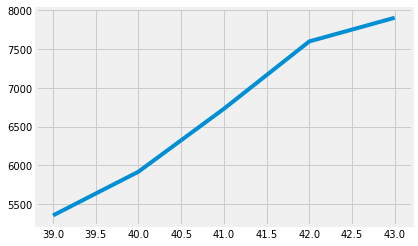

In [0]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [0]:
#Kafi confusing hai raat ko koshih krta hu

In [0]:
from datetime import datetime
import requests
import os
import glob
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [0]:
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSc_2y5N0I67wDU38DjDh35IZSIS30rQf7_NYZhtYYGU1jJYT6_kDx4YpF-qw0LSlGsBYP8pqM_a1Pd/pubhtml#'
req = requests.get(link)
soup = BeautifulSoup(req.content, "html.parser")

In [0]:
def getDataFromSheet(id, index):
  table = soup.find(id=id).div.table
  tbody = table.tbody
  body = tbody.find_all('tr')

  body_rows = []
    
  for tr in body:
      td = tr.find_all(['th', 'td'])
      row = [i.text for i in td]
      body_rows.append(row)
    
  data = pd.DataFrame(body_rows[index:len(body_rows)], columns=body_rows[0])

  data.drop(data.columns[0], axis='columns', inplace=True)
  return data

In [0]:
# Statewise tested numbers data

testing_data = getDataFromSheet(id='486127050', index=3)
testing_data['Updated On'].replace('', np.nan, inplace=True)
testing_data.dropna(subset=['Updated On'], inplace=True)
testing_data.drop(['Total People In Quarantine', 'Total People Released From Quarantine', 'Num Isolation Beds', 'Num ICU Beds', 'Num Ventilators', 'Source', 'Source2'], axis=1, inplace=True)
testing_data.head(5)

,Updated On,State,Total Tested,Positive,Negative,Unconfirmed,Num Calls State Helpline
0,01/04/2020,West Bengal,659,37,568,54,
1,01/04/2020,Kerala,7965,265,7256,444,
2,02/04/2020,Kerala,8456,286,7622,548,
3,02/04/2020,Andhra Pradesh,1800,132,1175,493,
4,02/04/2020,Assam,962,16,819,127,


In [0]:
list(testing_data.columns)
testing_data.drop(['Num Calls State Helpline'], axis=1, inplace=True)
# testing_data['Total_Tested'].replace('', np.nan, inplace=True)
# testing_data.dropna(subset=['Total_Tested'], inplace=True)
testing_data.head(5)

,Updated On,State,Total Tested,Positive,Negative,Unconfirmed
0,01/04/2020,West Bengal,659,37,568,54
1,01/04/2020,Kerala,7965,265,7256,444
2,02/04/2020,Kerala,8456,286,7622,548
3,02/04/2020,Andhra Pradesh,1800,132,1175,493
4,02/04/2020,Assam,962,16,819,127


In [0]:
testing_data['Updated On'] = pd.to_datetime(testing_data['Updated On'], format='%d/%m/%Y')
testing_data.head(5)

,Updated On,State,Total Tested,Positive,Negative,Unconfirmed
0,2020-04-01,West Bengal,659,37,568,54
1,2020-04-01,Kerala,7965,265,7256,444
2,2020-04-02,Kerala,8456,286,7622,548
3,2020-04-02,Andhra Pradesh,1800,132,1175,493
4,2020-04-02,Assam,962,16,819,127


In [0]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

# Supress Warnings
import warnings
warnings.simplefilter('ignore')

In [0]:
testing_data.replace(to_replace ="", 
                 value ="0", inplace=True)
testing_data['Total Tested'] = testing_data['Total Tested'].astype(float)
testing_data['Positive'] = testing_data['Positive'].astype(float)
testing_data['Negative'] = testing_data['Negative'].astype(float)
testing_data['Unconfirmed'] = testing_data['Unconfirmed'].astype(float)

In [0]:
last_updated_on = testing_data['Updated On'].max()

# most_tested_cities = testing_data.sort_values('Total Tested', ascending=False)[:10]
# most_tested_cities['State']

# grouped_testing_data = testing_data.groupby(['Updated On'])['Total Tested']
grouped_testing_data = testing_data
grouped_testing_data = grouped_testing_data.sort_values(['Total Tested'],ascending=False)
# grouped_testing_data
'''fig = px.bar(grouped_testing_data,
             x='Updated On', y='Total Tested',
             title='Tests Conducted state-wise in India: ', text='Total Tested', height=800, width=1000)
fig.show()'''
grouped_testing_data = grouped_testing_data.groupby('Updated On')['Total Tested', 'Positive', 'Negative',
       'Unconfirmed'].sum().reset_index()
grouped_testing_data

,Updated On,Total Tested,Positive,Negative,Unconfirmed
0,2020-02-04,9744.0,306.0,8586.0,852.0
1,2020-04-01,8624.0,302.0,7824.0,498.0
2,2020-04-02,14906.0,510.0,12622.0,1774.0
3,2020-04-03,20130.0,898.0,17242.0,1990.0
4,2020-04-04,1042.0,0.0,0.0,0.0
5,2020-04-05,59455.0,1493.0,53149.0,3640.0
6,2020-04-06,29698.0,1196.0,25462.0,795.0
7,2020-04-07,79123.0,3014.0,65229.0,4324.0
8,2020-04-08,63058.0,2473.0,52602.0,3509.0
9,2020-04-09,122239.0,4939.0,103024.0,6154.0


In [0]:
# import time module to access time based functions
import time

# Create the date we want to exclude and convert it be a time object
d1 = "2020-02-04"
newdate1 = time.strptime(d1, "%Y-%m-%d")

# remove the date
grouped_testing_data = grouped_testing_data[grouped_testing_data['Updated On'] != d1 ]
grouped_testing_data

,Updated On,Total Tested,Positive,Negative,Unconfirmed
1,2020-04-01,8624.0,302.0,7824.0,498.0
2,2020-04-02,14906.0,510.0,12622.0,1774.0
3,2020-04-03,20130.0,898.0,17242.0,1990.0
4,2020-04-04,1042.0,0.0,0.0,0.0
5,2020-04-05,59455.0,1493.0,53149.0,3640.0
6,2020-04-06,29698.0,1196.0,25462.0,795.0
7,2020-04-07,79123.0,3014.0,65229.0,4324.0
8,2020-04-08,63058.0,2473.0,52602.0,3509.0
9,2020-04-09,122239.0,4939.0,103024.0,6154.0
10,2020-04-10,155907.0,6490.0,134416.0,5502.0


In [0]:
fig = px.bar(grouped_testing_data,
             x='Updated On', y='Total Tested',
             title='Tests Conducted state-wise in India: ', text='Total Tested', height=800, width=1000)
fig.show()

# Quick Analysis

In [0]:
flg = data.groupby('Detected state')['confirmed', 'death', 'recovered', 'active'].sum().reset_index()

flg['mortalityRate'] = round((flg['death']/flg['confirmed'])*100, 2)

temp = flg[flg['confirmed']>10]
temp = temp.sort_values('mortalityRate', ascending=False)

# print(flg)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:8][::-1],
             x = 'mortalityRate', y = 'Detected state', 
             title='Deaths per 10 Confirmed Cases', text='mortalityRate', height=500, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

NameError: ignored

# Git Integration:

## File > Save a Copy to Git